# LogisticRegression

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import shap
import time
import json
import config as cfg

from category_encoders import WOEEncoder
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances

from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_validate,
    cross_val_score
)

cv_dev = StratifiedKFold(n_splits=cfg.N_SPLITS, shuffle=True, random_state=cfg.SEED)
cv_test = RepeatedStratifiedKFold(n_splits=cfg.N_SPLITS, n_repeats=cfg.N_REPEATS, random_state=cfg.SEED)

np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

sns.set_context("paper", font_scale=1.4)
sns.set_style("darkgrid")

In [2]:
MODEL_NAME = 'LogisticRegression'

In [3]:
# Load data
X_train = pd.read_csv(os.path.join("Data", "data_preprocessed_binned", "X_train.csv"))
X_test = pd.read_csv(os.path.join("Data", "data_preprocessed_binned", "X_test.csv"))
y_train = pd.read_csv(os.path.join("Data", "data_preprocessed_binned", "y_train.csv"))
y_test = pd.read_csv(os.path.join("Data", "data_preprocessed_binned", "y_test.csv"))

X_train

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
0,"(0.261, 7.373]","(0.659, 0.757]","(-479.96099999999996, -0.167]","(0.0010799999999999998, 0.702]","(-66.021, -38.018]","(0.00316, 35.551]","(0.296, 649.23]","(0.305, 0.49]","(1.05, 1.119]","(0.229, 0.323]","(0.316, 681.54]","(0.485, 0.826]","(0.0878, 0.115]","(0.296, 649.23]","(466.15, 755.02]","(0.561, 0.924]","(1.319, 1.514]","(0.296, 649.23]","(0.0777, 0.111]","(3.22, 10.306]","(1.067, 1.124]","(0.293, 681.54]","(0.066, 0.0948]","(0.296, 0.408]","(0.18, 0.27]","(0.499, 0.833]","(0.591, 1.118]","(-3829.9010000000003, -0.315]","(3.739, 3.932]","(0.105, 0.157]","(0.0877, 0.124]","(50.216, 62.646]","(5.783, 7.216]","(0.219, 0.652]","(0.295, 626.92]","(3.722, 9742.3]","(14.731, 48.366]","(0.202, 0.348]","(0.0799, 0.112]","(0.0405, 0.0698]","(0.0348, 0.056]","(0.0814, 0.112]","(-48532.001, 38.515]","(-48532.001, 18.277]","(3.333, 113820.0]","(-8.244, 0.344]","(2.997, 10.585]","(0.254, 623.85]","(0.0529, 0.0844]","(0.0010799999999999998, 0.465]","(0.606, 0.765]","(0.137, 0.172]","(0.246, 0.535]","(-3828.9010000000003, 0.581]","(-1805200.001, -1506.59]","(0.0797, 0.111]","(0.605, 147.19]","(0.894, 0.926]","(0.00485, 0.249]","(28.123, 59.311]","(19.756, 26862.0]","(45.512, 56.809]","(6.383, 7.982]","(5.976, 8.404]"
1,"(0.0261, 0.0495]","(0.322, 0.403]","(0.264, 0.351]","(1.857, 2.375]","(-38.018, -18.062]","(0.00316, 35.551]","(0.0334, 0.0601]","(1.431, 2.046]","(1.05, 1.119]","(0.575, 0.658]","(0.0267, 0.0532]","(0.0843, 0.169]","(0.0662, 0.0878]","(0.0334, 0.0601]","(1125.7, 1702.6]","(0.157, 0.245]","(2.476, 3.098]","(0.0334, 0.0601]","(0.0345, 0.0535]","(102.604, 70962.0]","(0.937, 0.981]","(0.0397, 0.0676]","(0.0284, 0.045]","(0.296, 0.408]","(0.541, 0.643]","(0.142, 0.219]","(0.591, 1.118]","(0.444, 0.733]","(4.592, 4.966]","(0.349, 0.466]","(0.0421, 0.0621]","(113.795, 144.51]","(2.489, 3.172]","(0.05, 0.219]","(0.0378, 0.0652]","(0.733, 1.035]","(2.878, 4.406]","(0.671, 0.733]","(0.0559, 0.0799]","(-12.546, 0.0193]","(0.117, 0.17]","(0.0576, 0.0814]","(190.987, 1562300.0]","(70.991, 85.36]","(0.0378, 0.139]","(0.658, 0.815]","(117.316, 6084200.0]","(0.0226, 0.0552]","(0.0308, 0.0529]","(1.448, 1.838]","(0.286, 0.352]","(0.311, 0.394]","(1.175, 1.474]","(1.361, 1.624]","(13497.6, 3657400.0]","(0.055, 0.0797]","(0.0297, 0.0748]","(0.926, 0.95]","(0.00485, 0.249]","(-0.001, 3.456]","(4.237, 5.105]","(103.086, 131.252]","(2.738, 3.497]","(1.962, 2.663]"
2,"(-0.105, -0.0227]","(0.133, 0.231]","(0.264, 0.351]","(2.375, 3.285]","(37.014, 68.646]","(-508.411, 0.0]","(-0.108, -0.0222]","(3.201, 6.227]","(0.844, 1.005]","(0.746, 0.852]","(-65.625, -0.079]","(-455.59099999999995, -0.241]","(-0.0409, 0.00945]","(-0.108, -0.0222]","(-2207.9, 74.043]","(-214.671, -0.0902]","(4.303, 7.397]","(-0.108, -0.0222]","(-0.0762, -0.0129]","(10.306, 17.417]","(0.789, 0.877]","(-65.625, -0.0527]","(-0.0732, -0.0128]","(-75.33200000000001, -0.11]","(0.767, 48.669]","(-214.671, -0.0874]","(-0.969, 0.0]","(0.444, 0.733]","(3.278, 3.53]","(-0.0234, 0.0515]","(-0.0743, -0.00945]","(25.512, 38.33]","(9.457, 14.155]","(-309.001, 0.05]","(-61.455999999999996, -0.0684]","(1.731, 2.002]",NaN,"(0.803, 0.88]","(-1395.801, -0.0475]","(0.883, 1.929]","(-1234.401, -0.0545]","(-1395.801, -0.0335]","(38.515, 55.024]","(28.793, 36.738]","(-2686.001, -0.636]","(2.28, 3.985]","(10.585, 18.232]","(-0.147, -0.0606]","(-0.112, -0.0407]","(2.599, 4.38]","(0.165, 0.224]","(0.0699, 0.105]","(1.474, 1.908]","(1.361, 1.624]","(365.692, 832.67]","(-8534.601, -0.0504]","(-0.212, -0.00791]","(1.002, 1.058]","(-189.58100000000002, 0.0]","(18.19, 

### Test performance

test_gini:	 0.6384
test_ap:	 0.2534


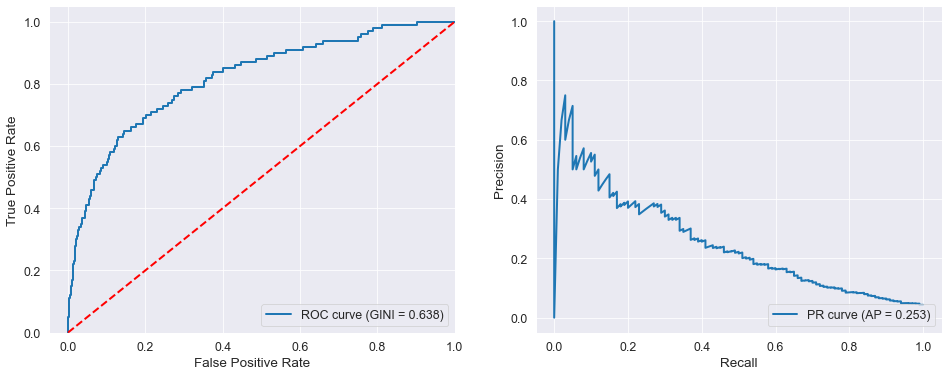

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

model = Pipeline([("encoder", WOEEncoder()), ("lr", LogisticRegression(random_state=cfg.SEED))])
model.fit(X = X_train, y = np.ravel(y_train))

# Calculate metrics
preds = model.predict_proba(X_test)[::,1]
test_gini = metrics.roc_auc_score(y_test, preds)*2-1
test_ap = metrics.average_precision_score(y_test, preds)
print(f"test_gini:\t {test_gini:.4}")
print(f"test_ap:\t {test_ap:.4}")

# ROC
test_auc = metrics.roc_auc_score(y_test, preds)

fpr, tpr, _ = metrics.roc_curve(y_test, preds)
lw = 2
axs[0].plot(fpr, tpr, lw=lw, label="ROC curve (GINI = %0.3f)" % test_gini)
axs[0].plot([0, 1], [0, 1], color="red", lw=lw, linestyle="--")
axs[0].set_xlim([-0.05, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend(loc="lower right")

# PR
precision, recall, _ = metrics.precision_recall_curve(y_test, preds)
lw = 2
axs[1].plot(recall, precision, lw=lw, label="PR curve (AP = %0.3f)" % test_ap)
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend(loc="lower right")

plt.savefig(os.path.join("Graphs", f"ROC_PRC_{MODEL_NAME}.png"), facecolor="w", dpi=100, bbox_inches = "tight")

In [5]:
# Cross-validation GINI
scores_gini = cross_validate(
    model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv_test, return_train_score=True, n_jobs=-1
)

mean_train_gini = (scores_gini["train_score"]*2-1).mean()
mean_test_gini = (scores_gini["test_score"]*2-1).mean()
std_test_gini = (scores_gini["test_score"]*2-1).std()

print(f"mean_train_gini:\t {mean_train_gini:.4}")
print(f"mean_dev_gini:\t\t {mean_test_gini:.4} (+-{std_test_gini:.1})")

mean_train_gini:	 0.765
mean_dev_gini:		 0.6267 (+-0.05)


### Model analysis

BAD    0.090909
dtype: float64


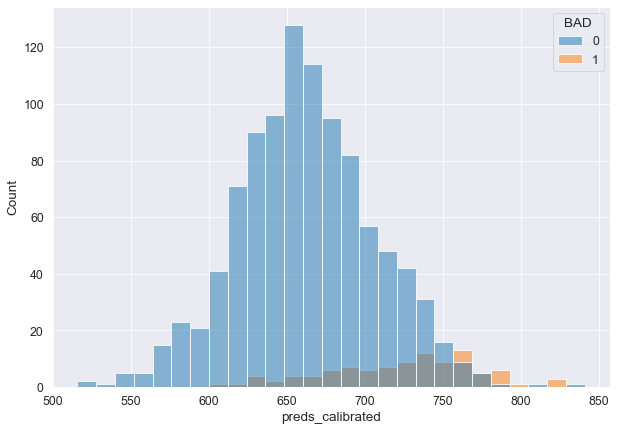

In [6]:
rus = RandomUnderSampler(sampling_strategy=cfg.SAMPLING_STRATEGY)
X_sub, y_sub = rus.fit_resample(X_test, y_test)
print(y_sub.mean())

preds = model.predict_proba(X_sub)[::,1]
preds_calibrated = pd.DataFrame(np.round(28.85*np.log(preds/(1-preds))+765.75), columns=["preds_calibrated"])

fig, axs = plt.subplots(1, 1, figsize=(10,7))
palette ={0: "C0", 1: "C1"}
sns.histplot(data=preds_calibrated, x="preds_calibrated", hue=y_sub['BAD'], palette=palette, ax=axs, bins='auto')

plt.savefig(os.path.join("Graphs", f"Score_distr_{MODEL_NAME}.png"), facecolor="w", dpi=100, bbox_inches = "tight")

In [7]:
# Logistic regression coefficients
coefs = pd.DataFrame(
    zip(X_train.columns, model["lr"].coef_[0]), columns=["Variable", "Coef"]
)
coefs_sorted = coefs.reindex(coefs["Coef"].abs().sort_values(ascending=False).index)
coefs_sorted

,Variable,Coef
47,Attr48,-1.346781
48,Attr49,-1.257748
46,Attr47,1.206742
43,Attr44,-1.189857
26,Attr27,1.106346
...,...,...
9,Attr10,0.052186
7,Attr8,-0.051056
24,Attr25,-0.039283
19,Attr20,0.029209


In [8]:
# Save results for final summary
results = {
    "test_gini": test_gini,
    "test_ap": test_ap,
    "optimization_time": 0,
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "precision": precision.tolist(),
    "recall": recall.tolist(),
    "mean_train_gini": scores_gini["train_score"].tolist(),
    "mean_test_gini": scores_gini["test_score"].tolist(),
}

with open(os.path.join("Results", f"Results_{MODEL_NAME}.json"), 'w') as fp:
    json.dump(results, fp)